# Prediction-Powered Inference
Based on the code from https://github.com/aangelopoulos/prediction-powered-inference

To run this notebook, you also need the files called ppi and ols_utils!

In [ ]:
%load_ext autoreload
%autoreload 2
!pip install folktables
import sys
sys.path.insert(1, '../')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from ppi import ols, classical_ols_interval, pp_ols_interval
from tqdm import tqdm
import matplotlib.pyplot as plt
from ols_utils import get_data, plot_data, transform_features, get_tree, make_plots
import seaborn as sns
# mount drive
from google.colab import drive
drive.mount("/content/gdrive")
# load data for monthly performance
data = pd.read_csv("/content/gdrive/MyDrive/Aurora_Thesis/data_converted.csv")

In [ ]:
# load my data and do cleaning
pd.set_option('display.max_columns', None)
#data = pd.read_csv("data_converted.csv")
data.time = pd.to_datetime(data.time)
data = data.reset_index()
# need to manually add 2 station Id
data.loc[data.station== "Bologna (BO)", "station_id"] = "ID1999"
data.loc[data.station== "San Pietro Capofiume (SPC)", "station_id"] = "ID1998"
# switch London data
data["OAtot_2"] = data.HOA_PMF + data.BBOA_PMF + data.OOAtot_PMF
data.loc[data.station == "London","OAtot_PMF"] = data.loc[data.station == "London","OAtot_2"]
# Remove Zurich 2017
data = data.loc[(data.station != "Zurich") | (data.year != 2017),:]
# CLEAN DATA
# remove OA with less than 0.1
data= data.loc[data.OAtot_PMF >= 0.1, :]
# and stations with less than 30 obs.
select = (data.groupby("station_id")["OAtot_PMF"].size() > 30).reset_index()
data = data.set_index("station_id")
data = data.join(select.set_index("station_id"), rsuffix = "keep")
data = data.loc[ data.OAtot_PMFkeep == True, :]
data = data.reset_index()
# add day of week
data["day_week"] = data.time.dt.day_of_week

## Interval Constructions

Here we give constructions for the imputed, classical, and prediction-powered OLS confidence intervals.

In [ ]:
def trial(ols_features_2019, income_2019, predicted_income_2019, n, alpha, sandwich=True):
    X_labeled, X_unlabeled, Y_labeled, Y_unlabeled, Yhat_labeled, Yhat_unlabeled = train_test_split(ols_features_2019, income_2019, predicted_income_2019, train_size=n)
    X = np.concatenate([X_labeled, X_unlabeled],axis=0)

    Yhat = np.concatenate([Yhat_labeled, Yhat_unlabeled], axis=0)

    imputed_interval = classical_ols_interval(X, Yhat, alpha, sandwich=sandwich)

    classical_interval = classical_ols_interval(X_labeled, Y_labeled, alpha, sandwich=sandwich)

    pp_interval = pp_ols_interval(X_labeled, X_unlabeled, Y_labeled, Yhat_labeled, Yhat_unlabeled, alpha, sandwich=sandwich)

    return imputed_interval, classical_interval, pp_interval

In [ ]:
data.head()

True OLS coefficients: [0.12816496 0.05812623]


100%|██████████| 50/50 [00:02<00:00, 17.43it/s]


<Figure size 1600x900 with 0 Axes>

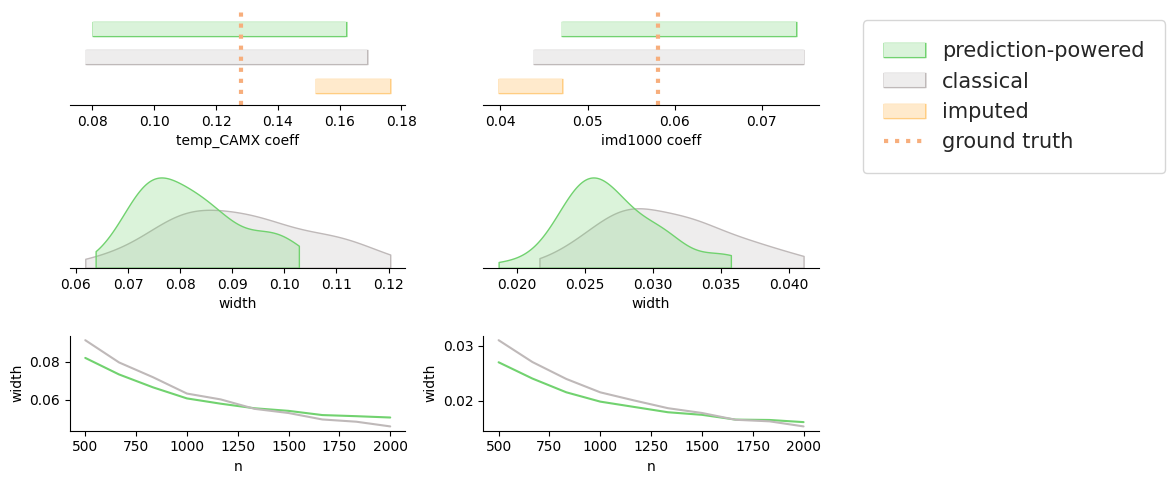

In [ ]:
# only from online dataset
data = data.loc[data.dataset == "online",:]
# choose features of linear models

covars = ["temp_CAMX","imd1000"]
X1 = data.loc[:, covars]
X1 = X1.fillna(0)

# ground truth labels (we will randomly sample from these to compute the "classical approach")
Y = data.loc[:, "OAtot_PMF"]
# CAMx predictions
Yhat = data.loc[:, "OAtot_CAMX"]
# True OLS
true = ols(X1,Y)
# Collect OLS features and do PPI
print(f"True OLS coefficients: {true}")

N = X1.shape[0]
num_n = 10
ns = np.linspace(500, 2000, num_n).astype(int)
num_trials = 50
alpha = 0.05
# Store results
columns = ["lb","ub","covered","estimator","coefficient","n"]
features = covars[:2]
results = []
for i in tqdm(range(num_trials)):
    for j in range(ns.shape[0]):
        n = ns[j]
        ii, ci, ppi = trial(np.array(X1), np.array(Y), np.array(Yhat), n, alpha, True)
        temp_df = pd.DataFrame(np.zeros((6,len(columns))), columns=columns)
        temp_df.loc[0] = ii[0][0], ii[1][0], (ii[0][0] <= true[0]) & (true[0] <= ii[1][0]), "imputed", features[0], n
        temp_df.loc[1] = ci[0][0], ci[1][0], (ci[0][0] <= true[0]) & (true[0] <= ci[1][0]), "classical", features[0], n
        temp_df.loc[2] = ppi[0][0], ppi[1][0], (ppi[0][0] <= true[0]) & (true[0] <= ppi[1][0]), "prediction-powered", features[0], n
        temp_df.loc[3] = ii[0][1], ii[1][1], (ii[0][1] <= true[1]) & (true[1] <= ii[1][1]), "imputed", features[1], n
        temp_df.loc[4] = ci[0][1], ci[1][1], (ci[0][1] <= true[1]) & (true[1] <= ci[1][1]), "classical", features[1], n
        temp_df.loc[5] = ppi[0][1], ppi[1][1], (ppi[0][1] <= true[1]) & (true[1] <= ppi[1][1]), "prediction-powered", features[1], n
        results += [temp_df]
df = pd.concat(results)
df["width"] = df["ub"] - df["lb"]
plt.figure(figsize = (16,9))
make_plots(df, true, features[0], features[1])


# NOW FOR OA COMPONENTS

It does not seem to be beneficial to do PPI. Maybe some transofrmations can help. Or the simulator is just not good enough!

In [ ]:
# only from online dataset
data = data.loc[data.dataset == "online",:]
PMF = data.loc[(data.HOA_PMF.isnull() == False) | (data.BBOA_PMF.isnull() == False) | (data.OOAtot_PMF.isnull() == False), :]
PMF = PMF.loc[PMF.station != "SMEARII",:]
# Now NAN should be zeros
PMF = PMF.fillna(0)
# features of linear models
covars = ["Lat","population_1000","Lon","elevation","press_CAMX","ws_CAMX", "temp_CAMX","imd1000", "industrial1000","pblh_CAMX", "day_week","area_grid",]
X1 = PMF.loc[:, covars]
X1 = X1.fillna(0)
# ground truth labels is now one of the OA components obtained from the PMF results.
Y = PMF.loc[:, "HOA_PMF"]
Y = Y.fillna(0)
# CAMx predictions (predicted OA components using CAMx)
Yhat = PMF.loc[:, "HOA_CAMX"]
Yhat = np.log(Yhat.fillna(0))
# True ols
true = ols(X1,Y)
# Collect OLS features and do PPI
print(f"True OLS coefficients: {true}")
N = X1.shape[0]
num_n = 10
ns = np.linspace(200, 2000, num_n).astype(int)
num_trials = 50
alpha = 0.05
# Store results
columns = ["lb","ub","covered","estimator","coefficient","n"]
features = covars[:2]
results = []
for i in tqdm(range(num_trials)):
    for j in range(ns.shape[0]):
        n = ns[j]
        ii, ci, ppi = trial(np.array(X1), np.array(Y), np.array(Yhat), n, alpha, True)
        temp_df = pd.DataFrame(np.zeros((6,len(columns))), columns=columns)
        temp_df.loc[0] = ii[0][0], ii[1][0], (ii[0][0] <= true[0]) & (true[0] <= ii[1][0]), "imputed", features[0], n
        temp_df.loc[1] = ci[0][0], ci[1][0], (ci[0][0] <= true[0]) & (true[0] <= ci[1][0]), "classical", features[0], n
        temp_df.loc[2] = ppi[0][0], ppi[1][0], (ppi[0][0] <= true[0]) & (true[0] <= ppi[1][0]), "prediction-powered", features[0], n
        temp_df.loc[3] = ii[0][1], ii[1][1], (ii[0][1] <= true[1]) & (true[1] <= ii[1][1]), "imputed", features[1], n
        temp_df.loc[4] = ci[0][1], ci[1][1], (ci[0][1] <= true[1]) & (true[1] <= ci[1][1]), "classical", features[1], n
        temp_df.loc[5] = ppi[0][1], ppi[1][1], (ppi[0][1] <= true[1]) & (true[1] <= ppi[1][1]), "prediction-powered", features[1], n
        results += [temp_df]
df = pd.concat(results)
df["width"] = df["ub"] - df["lb"]
plt.figure(figsize = (16,9))
make_plots(df, true, features[0], features[1])
